In [1]:
import numpy as np
import fnmatch as fn
import Levenshtein as L
import sys
import os
import ast
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 68.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 138.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 218.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 288.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 368.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 438.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 508.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 578.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 628.00MB
INFO:tensorflow

In [20]:
PythonCodePath = []
FileName = []
DataPath = '/home/mahmoud/deid2/data'
Students = os.listdir(DataPath) 
print("Some of the codes for removing age are:")
for name in Students:
    Files = os.listdir(DataPath+'/'+name+'/'+'python')
    for file in Files:
        if fn.fnmatch(file, '*ge*.py'):
            PythonCodePath.append(DataPath+'/'+name+'/'+'python'+'/'+file)
            FileName.append(file)
            print(file)

Some of the codes for removing age are:
deid_age_mahmoud.py
de-id-age.py
deid_Age_Parisa.py


In [4]:
# Reading the python codes into a list.
PythonCode = []
for Code in PythonCodePath:
    with open(Code) as f:
        PythonCode.append(f.read())

In [13]:
# Finding the similarity between codes by using sentence embedding
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  PythonCode_embeddings = session.run(embed(PythonCode))

  for i, PythonCode_embedding in enumerate(np.array(PythonCode_embeddings).tolist()):
    print("Embedding size: {}".format(len(PythonCode_embedding)))
    PythonCode_embedding_snippet = ", ".join(
        (str(x) for x in PythonCode_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(PythonCode_embedding_snippet))

Embedding size: 512
Embedding: [-0.05343174189329147, -0.05529896914958954, 0.055460717529058456, ...]

Embedding size: 512
Embedding: [-0.05316411331295967, -0.05605647340416908, 0.05683531239628792, ...]

Embedding size: 512
Embedding: [-0.05195559561252594, -0.05369407311081886, 0.05380227416753769, ...]



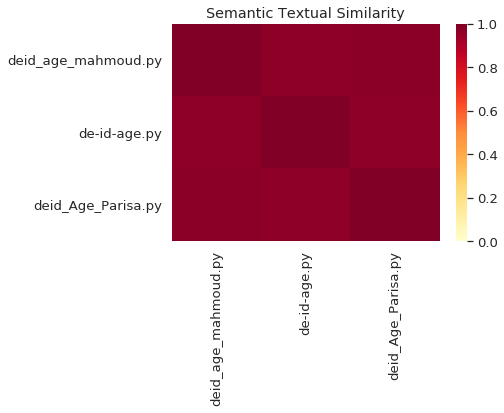

In [19]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, PythonCode_, encoding_tensor):
  code_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: PythonCode_})
  plot_similarity(FileName, code_embeddings_, 90)

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_code_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, PythonCode,
               similarity_code_encodings)

In [7]:
# Finding the similarity between codes by using Jaro Similarity, Levenshtein Distance, and Ratio.
JaroMat  = np.zeros((len(PythonCode),len(PythonCode)), dtype=np.float32)
LevenMat = np.zeros((len(PythonCode),len(PythonCode)), dtype=np.float32)
SimilarityMat = np.zeros((len(PythonCode),len(PythonCode)), dtype=np.float32)
for m in range(0,len(PythonCode)):
    for n in range(0,len(PythonCode)):
        JaroMat[m][n]  = L.jaro(PythonCode[m],PythonCode[n]) # Jaro string similarity metric
        LevenMat[m][n] = L.distance(PythonCode[m],PythonCode[n]) # Absolute Levenshtein distance
        SimilarityMat[m][n] = L.ratio(PythonCode[m],PythonCode[n]) # Similarity of two strings

Text(0.5, 1.0, 'Jaro string Similarity')

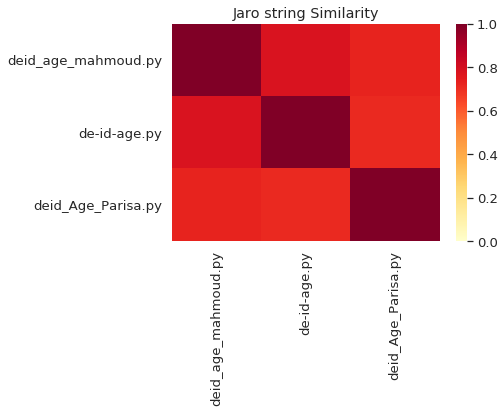

In [8]:
sns.set(font_scale=1.2)
g = sns.heatmap(
      JaroMat,
      xticklabels=FileName,
      yticklabels=FileName,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
g.set_xticklabels(FileName, rotation=90)
g.set_title("Jaro string Similarity")

Text(0.5, 1.0, 'Absolute Levenshtein distance')

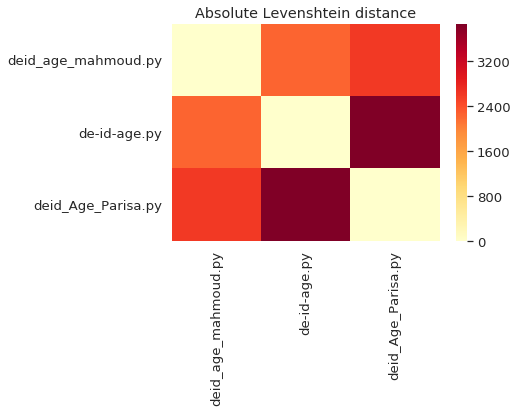

In [9]:
sns.set(font_scale=1.2)
g = sns.heatmap(
      LevenMat,
      xticklabels=FileName,
      yticklabels=FileName,
      cmap="YlOrRd")
g.set_xticklabels(FileName, rotation=90)
g.set_title("Absolute Levenshtein distance")

Text(0.5, 1.0, 'Similarity of two strings')

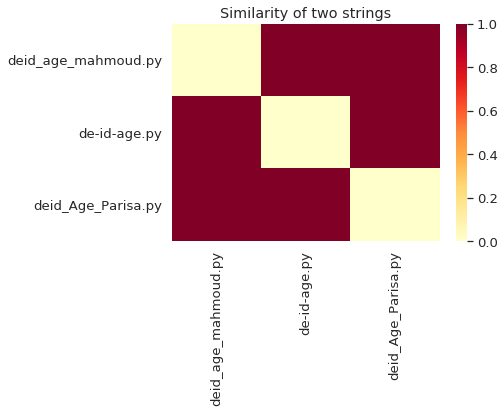

In [10]:
sns.set(font_scale=1.2)
g = sns.heatmap(
      LevenMat,
      xticklabels=FileName,
      yticklabels=FileName,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
g.set_xticklabels(FileName, rotation=90)
g.set_title("Similarity of two strings")

In [11]:
import pycode_similar
x=pycode_similar.detect([data[0], data[1]],diff_method=pycode_similar.TreeDiff)

NameError: name 'data' is not defined